In [63]:
import json
import os
import random
from PIL import Image
from pycocotools import mask as maskUtils
import matplotlib.pyplot as plt
import numpy as np

# img_dir = '/data/mhp/LV-MHP-v2/val/images'
# coco_ann_file = '/data/mhp/LV-MHP-v2/val.json'

# img_dir = "/data/VOCdevkit/VOC2012/JPEGImages"
# coco_ann_file = '/data/pascal_panoptic_parts/validation.json'

# img_dir = "/data/textvqa/images"
# coco_ann_file = '/data/textvqa/textocr_val.json'

# img_dir = "/data/coco/images/val2017/"
# coco_ann_file = '/data/coco/annotations/panoptic_detectron2_val2017.json'
# coco_ann_file = "/data/lvis/lvis_v1_val.json"

# img_dir = "/data/coco/images/train2017/"
# coco_ann_file = "/data/lvis/lvis_v1_val.json"

# img_dir = "/data/Adobe_EntitySeg/images_lr"
# coco_ann_file = '/data/entityseg/entityseg_val_lr.json'
# coco_ann_file = '/data/entityseg/entityseg_train_lr_no_cls.json'

img_dir = "/data/coco/images/val2017/"
coco_ann_file = '/data/coco/annotations/panoptic_lvis_merged_val.json'

with open(coco_ann_file) as f:
    data = json.load(f)

img_id_to_info = {}
for img_info in data['images']:
    img_id_to_info[img_info['id']] = img_info

img_id_to_anns = {}
for ann in data['annotations']:
    img_id = ann['image_id']
    if img_id not in img_id_to_anns:
        img_id_to_anns[img_id] = []
    img_id_to_anns[img_id].append(ann)

category_id_to_info = {}
for category_info in data['categories']:
    random_color = [random.randint(0, 255) for _ in range(3)]
    category_info['color'] = np.array(random_color).astype(np.uint8)
    category_id_to_info[category_info['id']] = category_info

54931
num anns:  8
{'fence', 'person', 'tree', 'dirt', 'belt', 'boot', 'horse'}


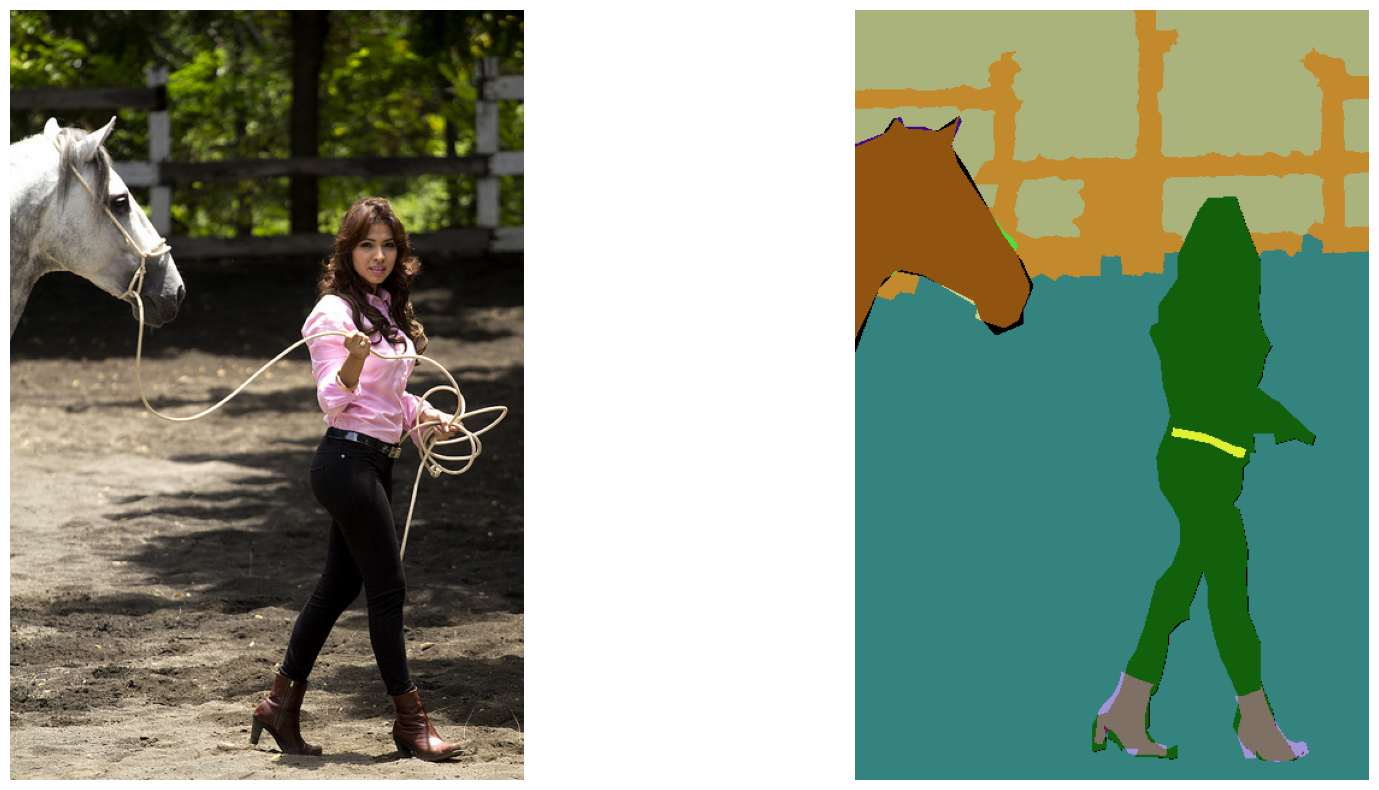

: 

In [65]:
img_id = random.choice(list(img_id_to_anns.keys()))
img_info = img_id_to_info[img_id]
img_file = os.path.join(img_dir, img_info['file_name'])
# img_file = os.path.join(img_dir, f"{img_info['id']:012d}.jpg")
img = Image.open(img_file)
anns = img_id_to_anns[img_id]

print(img_id)
print("num anns: ", len(anns))

no_category = all([ann['category_id'] == 0 for ann in anns])
if no_category:
    print("no category")

categories = []
mask_vis = np.zeros((img_info['height'], img_info['width'], 3), dtype=np.uint8)
for idx, ann in enumerate(anns):
    cat_id = ann['category_id']
    cat_info = category_id_to_info[cat_id]
    # print(cat_info['type'], cat_id, cat_info.get('name_text'))
    # mask = maskUtils.decode(ann['segmentation'])
    categories.append(cat_info['name_text'])
    # if "lvis" in coco_ann_file:
    #     print(cat_id, cat_info.get('synset'))
    #     rles = maskUtils.frPyObjects(ann['segmentation'], img_info['height'], img_info['width'])
    #     rle = maskUtils.merge(rles)
    #     mask = maskUtils.decode(rle)
    mask = maskUtils.decode(ann['segmentation'])
    color = cat_info['color'] if not no_category else np.array([random.randint(0, 255) for _ in range(3)]).astype(np.uint8)
    mask_vis += mask[:, :, None] * color

print(set(categories))

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img)
axes[0].axis('off')
axes[1].imshow(mask_vis)
axes[1].axis('off')
plt.show()

2008001813
num anns:  5
stuff 23 grass
stuff 70 tree
thing 2 bicycle
part 109 bicycle bwheel
part 110 bicycle saddle


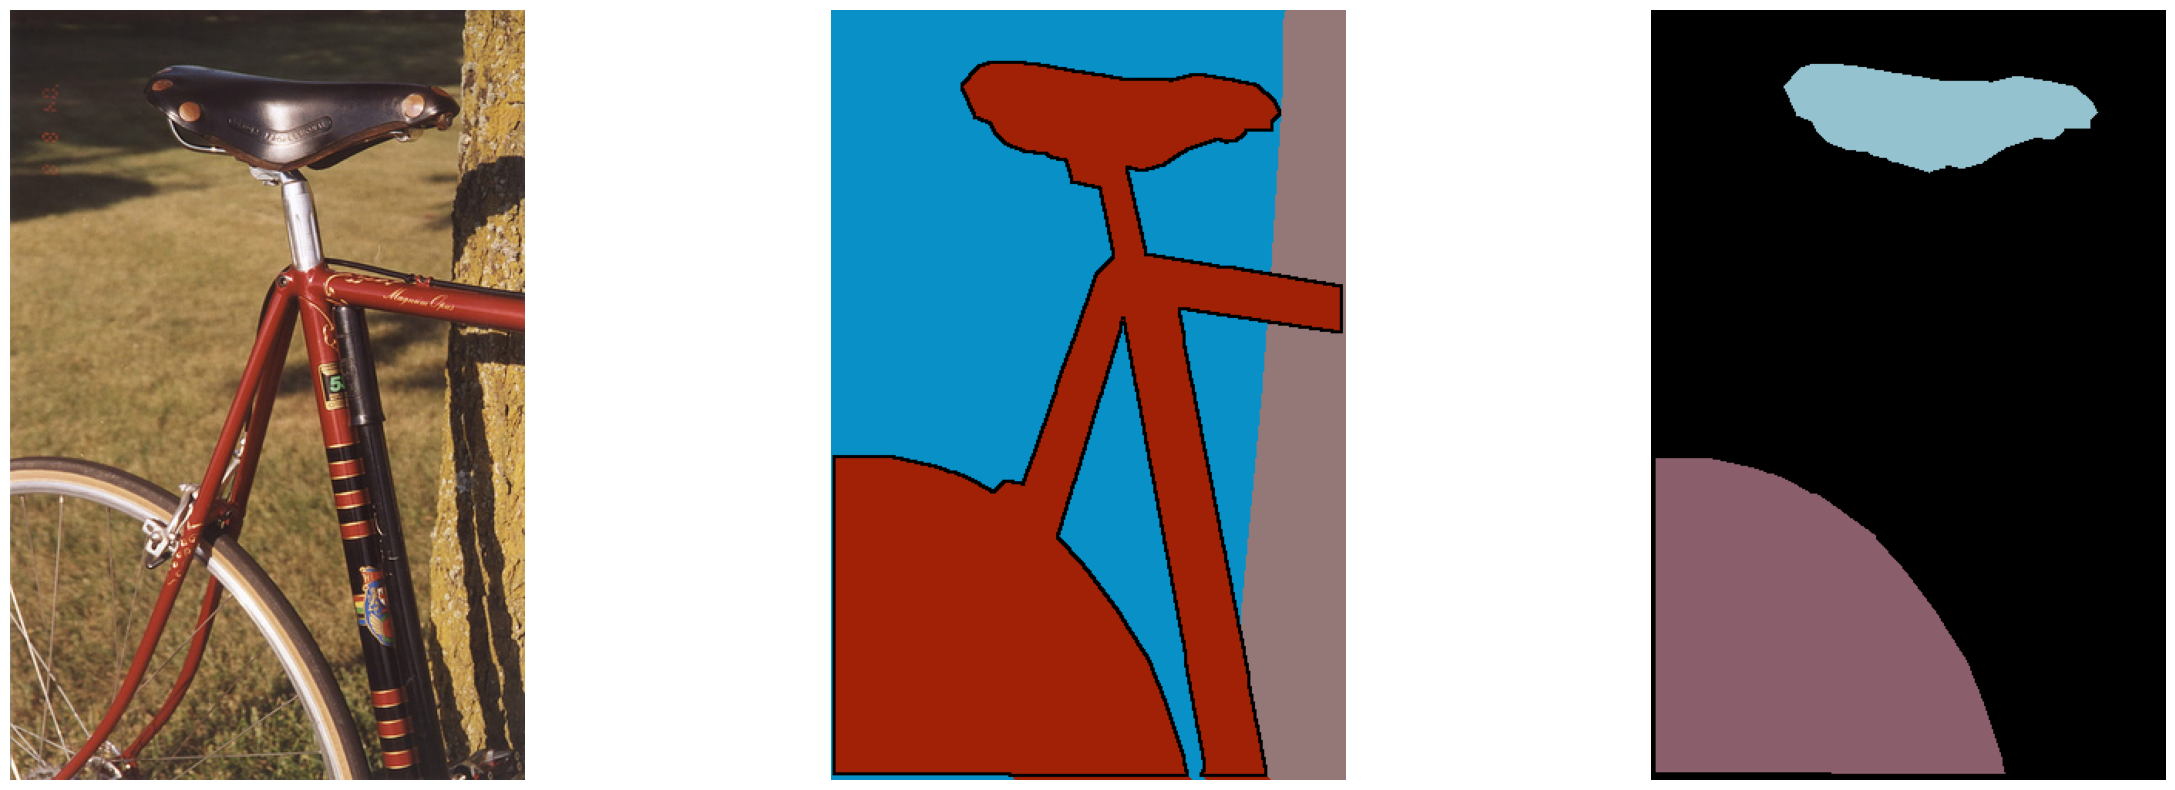

In [ ]:
img_id = random.choice(list(img_id_to_anns.keys()))
img_info = img_id_to_info[img_id]
img_file = os.path.join(img_dir, img_info['file_name'])
img = Image.open(img_file)
anns = img_id_to_anns[img_id]

print(img_id)
print("num anns: ", len(anns))

mask_vis = np.zeros((img_info['height'], img_info['width'], 3), dtype=np.uint8)
mask_vis_part = np.zeros((img_info['height'], img_info['width'], 3), dtype=np.uint8)
for idx, ann in enumerate(anns):
    cat_id = ann['category_id']
    cat_info = category_id_to_info[cat_id]
    print(cat_info['type'], cat_id, cat_info['name_text'])
    mask = maskUtils.decode(ann['segmentation'])
    if cat_info['type'] == "part":
        mask_vis_part += mask[:, :, None] * cat_info['color']
    else:
        mask_vis += mask[:, :, None] * cat_info['color']

fig, axes = plt.subplots(1, 3, figsize=(30, 10))
axes[0].imshow(img)
axes[0].axis('off')
axes[1].imshow(mask_vis)
axes[1].axis('off')
axes[2].imshow(mask_vis_part)
axes[2].axis('off')
plt.show()

0.9861944777911165


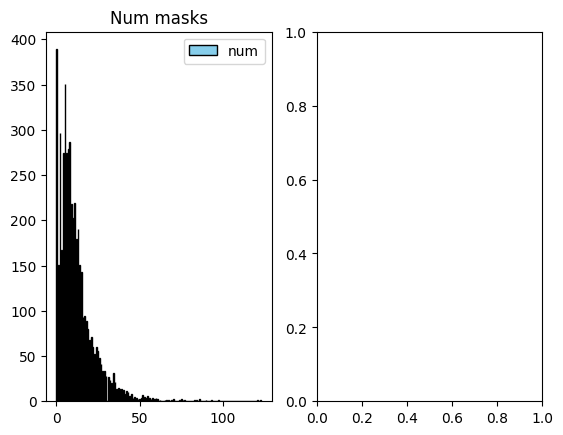

In [ ]:
pard_ids = {cat_info['id'] for cat_info in data['categories'] if cat_info['type'] == 'part'}

num_part_masks = []
for anns in img_id_to_anns.values():
    num = 0
    for ann in anns:
        cat_id = ann['category_id']
        if cat_id in pard_ids:
            num += 1
    num_part_masks.append(num)

# num_masks = sorted(num_masks, reverse=True)[100:]
num_masks_less = [n for n in num_part_masks if n < 50]
print(len(num_masks_less) / len(num_part_masks))

# num_masks_small = [n for n in mask_areas if n < 100]
# print(len(num_masks_small) / len(mask_areas))

fig, axs = plt.subplots(1, 2)

# bins = np.arange(min(num_masks), max(num_masks) + 2) - 0.5
axs[0].hist(
    num_part_masks,
    bins=250,
    color="skyblue",
    edgecolor="black",
    label="num",
)
axs[0].set_title("Num masks")
# axs[0].set_yscale("log")
axs[0].legend()


# axs[1].hist(
#     mask_areas,
#     bins=250,
#     color="skyblue",
#     edgecolor="black",
#     label="areas",
# )
# axs[1].set_title("Areas")
# axs[1].set_yscale("log")
# axs[1].legend()

